/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 38s 278ms/step - loss: 1.3335e-04 - mae: 0.0065 - val_loss: 9.9648e-04 - val_mae: 0.0232
Epoch 2/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 19s 178ms/step - loss: 1.1682e-05 - mae: 0.0021 - val_loss: 0.0020 - val_mae: 0.0356
Epoch 3/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 19s 164ms/step - loss: 1.6565e-05 - mae: 0.0029 - val_loss: 7.7625e-04 - val_mae: 0.0188
Epoch 4/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 18s 164ms/step - loss: 1.4229e-05 - mae: 0.0024 - val_loss: 0.0010 - val_mae: 0.0251
Epoch 5/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 21s 170ms/step - loss: 1.4391e-05 - mae: 0.0023 - val_loss: 3.5173e-04 - val_mae: 0.0121
Epoch 6/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 20s 165ms/step - loss: 1.2227e-05 - mae: 0.0024 - val_loss: 3.2456e-04 - val_mae: 0.0101
Epoch 7/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 20s 163ms/step - loss: 1.2527e-05 - mae: 0.0023 - val_loss: 2.9905e-04 - val_mae: 0.0097
Epoch 8/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 21s 170ms/step - loss: 1.1795e-05 - mae: 0.0020 - val_los

<ipython-input-9-a6a7b187e423>:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


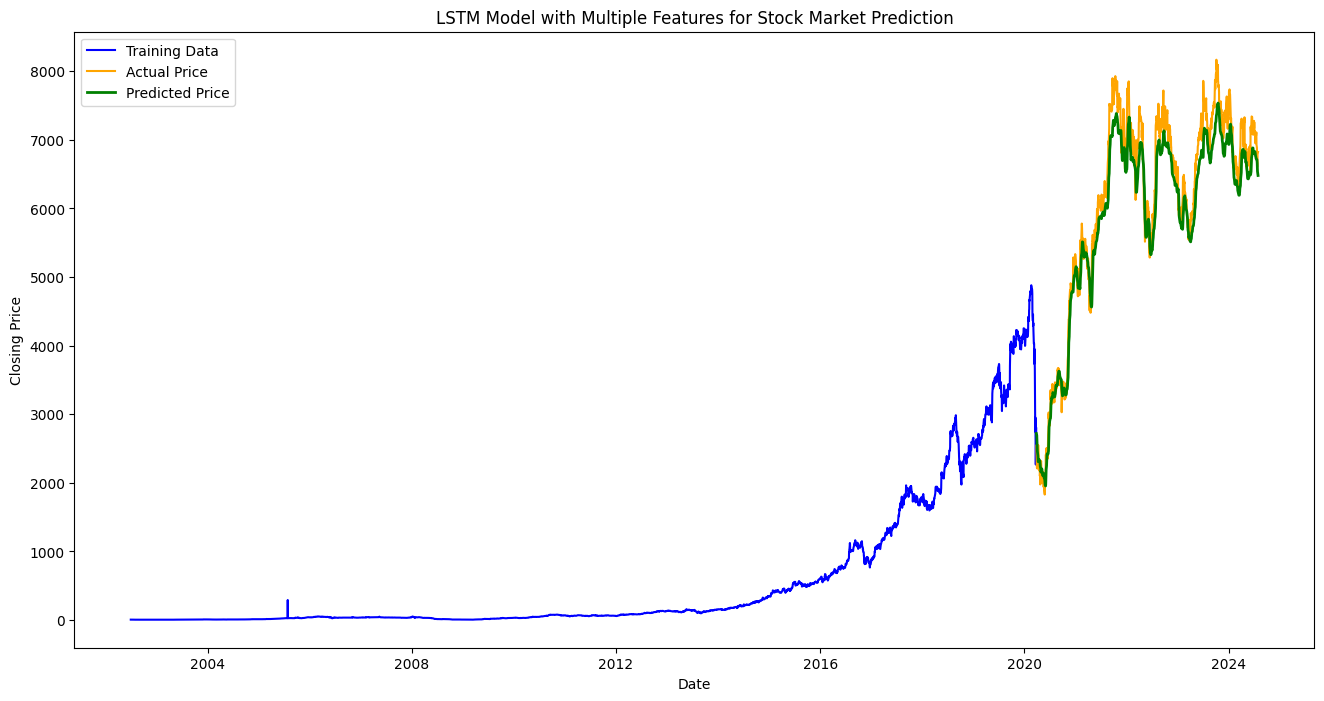

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

# Load and preprocess the data
df = pd.read_csv('/content/BAJFINANCE.NS (5).csv')  # Replace with the path to your CSV file

# Ensure the Date column is in the correct format and set as index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Drop NaN values
df = df.dropna()

# Scale the features 'Close', 'Open', 'High', 'Low', and 'Volume'
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[['Close', 'Open', 'High', 'Low', 'Volume']])

# Create datasets with multiple features (using 'Close', 'Open', 'High', 'Low', 'Volume')
def create_dataset_multifeature(dataset, look_back=120):
    X, y = [], []
    for i in range(look_back, len(dataset)):
        X.append(dataset[i-look_back:i])  # Include all features
        y.append(dataset[i, 0])  # Predict 'Close' price (index 0)
    return np.array(X), np.array(y)

# Increase the look-back window to capture longer trends
look_back = 120
X, y = create_dataset_multifeature(scaled_data, look_back)

# Reshape X to be [samples, time steps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], X.shape[2]))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Build the LSTM model with increased complexity
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.3))  # Adjust dropout for regularization
model.add(LSTM(units=100, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(units=50))  # Extra Dense layer for more complexity
model.add(Dense(units=1))  # Output layer

# Compile the model with a lower learning rate
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Train the model with early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train, batch_size=32, epochs=100, validation_split=0.2, callbacks=[early_stopping])

# Predictions and inverse transformation
predictions = model.predict(X_test)

# Inverse transformation for predictions
predictions = scaler.inverse_transform(
    np.concatenate((predictions, np.zeros((predictions.shape[0], X_test.shape[2]-1))), axis=1)
)[:, 0]

# Inverse transform y_test for comparison
y_test_scaled = scaler.inverse_transform(
    np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], X_test.shape[2]-1))), axis=1)
)[:, 0]

# Evaluation metrics
mse = mean_squared_error(y_test_scaled, predictions)
mae = mean_absolute_error(y_test_scaled, predictions)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")

# Plot the results with enhanced visibility
train = df[:len(X_train) + look_back]
valid = df[len(X_train) + look_back:]
valid['Predictions'] = predictions

plt.figure(figsize=(16,8))
plt.title('LSTM Model with Multiple Features for Stock Market Prediction')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.plot(train['Close'], label='Training Data', color='blue')
plt.plot(valid['Close'], label='Actual Price', color='orange')
plt.plot(valid['Predictions'], label='Predicted Price', color='green', linewidth=2)
plt.legend()
plt.show()

In [5]:
!pip install arch
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 982.9/982.9 kB 17.0 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 34s 205ms/step - loss: 1.3907e-04 - mae: 0.0071 - val_loss: 3.5363e-04 - val_mae: 0.0111
Epoch 2/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 17s 160ms/step - loss: 1.5946e-05 - mae: 0.0025 - val_loss: 3.9182e-04 - val_mae: 0.0130
Epoch 3/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 23s 182ms/step - loss: 1.7896e-05 - mae: 0.0026 - val_loss: 7.5612e-04 - val_mae: 0.0207
Epoch 4/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 18s 159ms/step - loss: 2.6021e-05 - mae: 0.0032 - val_loss: 0.0019 - val_mae: 0.0364
Epoch 5/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 23s 178ms/step - loss: 1.2433e-05 - mae: 0.0022 - val_loss: 3.4644e-04 - val_mae: 0.0121
Epoch 6/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 19s 160ms/step - loss: 1.3461e-05 - mae: 0.0022 - val_loss: 5.3763e-04 - val_mae: 0.0167
Epoch 7/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 18s 162ms/step - loss: 1.1382e-05 - mae: 0.0024 - val_loss: 2.9392e-04 - val_mae: 0.0106
Epoch 8/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 20s 162ms/step - loss: 1.4063e-05 - mae: 0.0024 - val

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

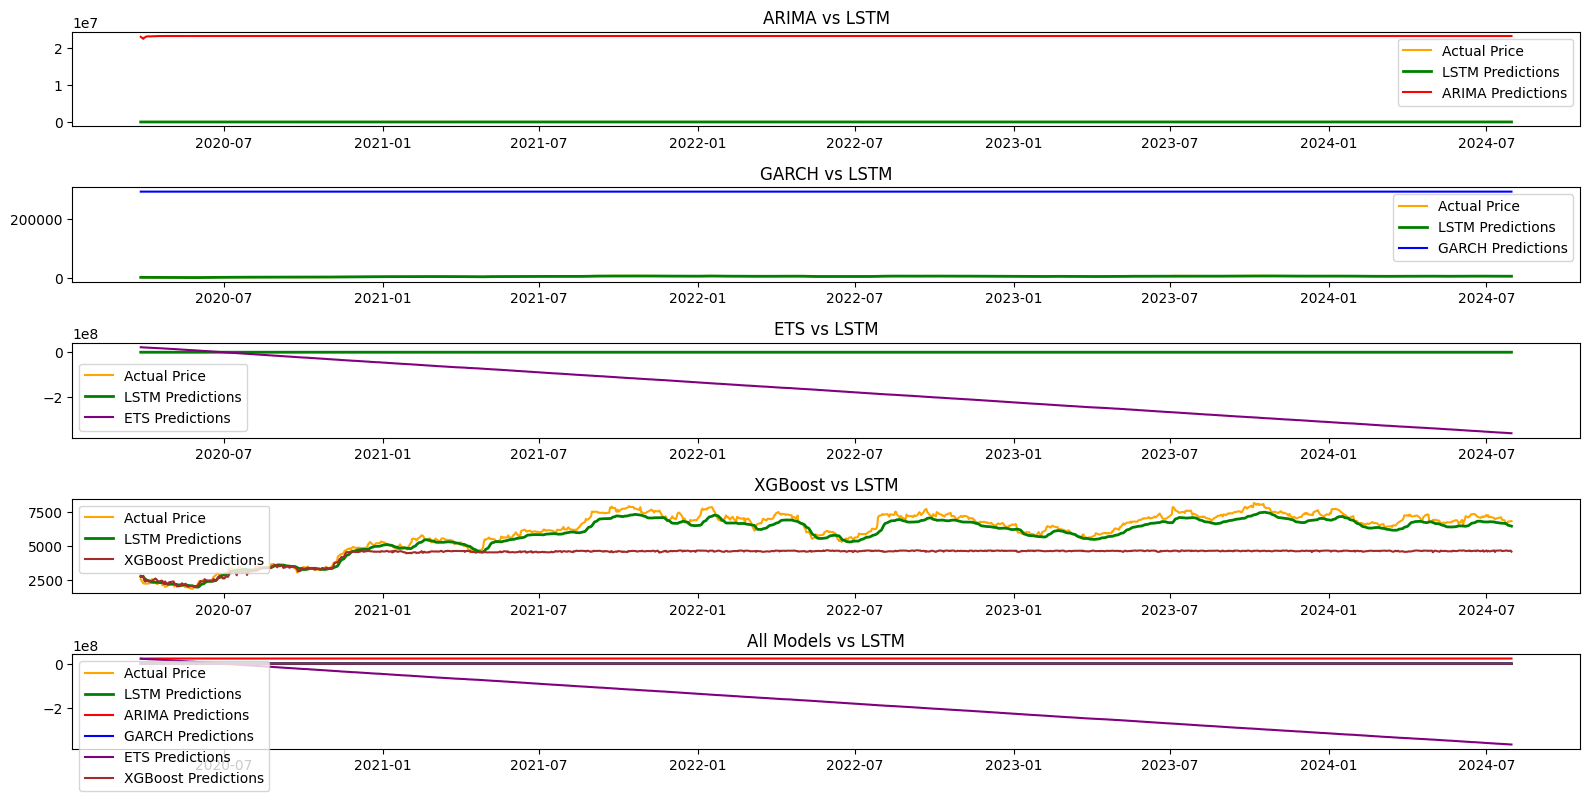

ARIMA - MSE: 539015771691604.7, MAE: 23216693.849306896
GARCH - MSE: 82494571850.14844, MAE: 287214.63212424266
ETS - MSE: 4.196713300547268e+16, MAE: 172835840.1561324
XGBoost - MSE: 4008610.3081452264, MAE: 1731.9860096646782
LSTM - MSE: 148511.70812979096, MAE: 321.06152395344066


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
import statsmodels.api as sm
from arch import arch_model
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import xgboost as xgb

# Load and preprocess the data
df = pd.read_csv('/content/BAJFINANCE.NS (5).csv')  # Replace with the path to your CSV file

# Ensure the Date column is in the correct format and set as index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Drop NaN values
df = df.dropna()

# Scale the features 'Close', 'Open', 'High', 'Low', and 'Volume'
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[['Close', 'Open', 'High', 'Low', 'Volume']])

# Create datasets with multiple features (using 'Close', 'Open', 'High', 'Low', 'Volume')
def create_dataset_multifeature(dataset, look_back=120):
    X, y = [], []
    for i in range(look_back, len(dataset)):
        X.append(dataset[i-look_back:i])  # Include all features
        y.append(dataset[i, 0])  # Predict 'Close' price (index 0)
    return np.array(X), np.array(y)

# Increase the look-back window to capture longer trends
look_back = 120
X, y = create_dataset_multifeature(scaled_data, look_back)

# Reshape X to be [samples, time steps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], X.shape[2]))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Build the LSTM model with increased complexity
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.3))  # Adjust dropout for regularization
model.add(LSTM(units=100, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(units=50))  # Extra Dense layer for more complexity
model.add(Dense(units=1))  # Output layer

# Compile the model with a lower learning rate
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Train the model with early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train, batch_size=32, epochs=100, validation_split=0.2, callbacks=[early_stopping])

# Predictions and inverse transformation
predictions = model.predict(X_test)

# Inverse transformation for predictions
predictions = scaler.inverse_transform(
    np.concatenate((predictions, np.zeros((predictions.shape[0], X_test.shape[2]-1))), axis=1)
)[:, 0]

# Inverse transform y_test for comparison
y_test_scaled = scaler.inverse_transform(
    np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], X_test.shape[2]-1))), axis=1)
)[:, 0]

# --- ARIMA Model ---
arima_order = (5, 1, 0)  # (p, d, q)
arima_model = sm.tsa.ARIMA(df['Close'][:len(X_train) + look_back], order=arima_order)
arima_fitted = arima_model.fit()
arima_predictions = arima_fitted.forecast(steps=len(X_test))

# Convert ARIMA predictions from Series to NumPy array for scaling
arima_predictions_np = np.array(arima_predictions).reshape(-1, 1)

# Inverse scale the ARIMA predictions
arima_predictions_scaled = scaler.inverse_transform(
    np.concatenate((arima_predictions_np, np.zeros((arima_predictions_np.shape[0], X_test.shape[2]-1))), axis=1)
)[:, 0]

# --- GARCH Model ---
garch_model = arch_model(df['Close'][:len(X_train) + look_back], vol='Garch', p=1, q=1)
garch_fitted = garch_model.fit(disp="off")
garch_forecast = garch_fitted.forecast(horizon=len(X_test))
garch_predictions = garch_forecast.mean.values[-1, :]

# Inverse scale the GARCH predictions
garch_predictions_scaled = scaler.inverse_transform(
    np.concatenate((garch_predictions.reshape(-1, 1), np.zeros((garch_predictions.shape[0], X_test.shape[2]-1))), axis=1)
)[:, 0]

# --- Exponential Smoothing (ETS) Model ---
ets_model = ExponentialSmoothing(df['Close'][:len(X_train) + look_back], trend='add', seasonal='add', seasonal_periods=12)
ets_fitted = ets_model.fit()
ets_predictions = ets_fitted.forecast(steps=len(X_test))

# Convert ETS predictions to NumPy array for scaling
ets_predictions_np = np.array(ets_predictions).reshape(-1, 1)

# Inverse scale the ETS predictions
ets_predictions_scaled = scaler.inverse_transform(
    np.concatenate((ets_predictions_np, np.zeros((ets_predictions_np.shape[0], X_test.shape[2]-1))), axis=1)
)[:, 0]

# --- XGBoost Model ---
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1)
xgb_model.fit(X_train.reshape(X_train.shape[0], -1), y_train)
xgb_predictions = xgb_model.predict(X_test.reshape(X_test.shape[0], -1))

# Inverse scale the XGBoost predictions
xgb_predictions_scaled = scaler.inverse_transform(
    np.concatenate((xgb_predictions.reshape(-1, 1), np.zeros((xgb_predictions.shape[0], X_test.shape[2]-1))), axis=1)
)[:, 0]

# Plot each model against LSTM
plt.figure(figsize=(16, 8))

# --- ARIMA vs LSTM ---
plt.subplot(5, 1, 1)
plt.plot(df.index[-len(y_test):], y_test_scaled, label='Actual Price', color='orange')
plt.plot(df.index[-len(y_test):], predictions, label='LSTM Predictions', color='green', linewidth=2)
plt.plot(df.index[-len(y_test):], arima_predictions_scaled, label='ARIMA Predictions', color='red')
plt.title('ARIMA vs LSTM')
plt.legend()

# --- GARCH vs LSTM ---
plt.subplot(5, 1, 2)
plt.plot(df.index[-len(y_test):], y_test_scaled, label='Actual Price', color='orange')
plt.plot(df.index[-len(y_test):], predictions, label='LSTM Predictions', color='green', linewidth=2)
plt.plot(df.index[-len(y_test):], garch_predictions_scaled, label='GARCH Predictions', color='blue')
plt.title('GARCH vs LSTM')
plt.legend()

# --- ETS vs LSTM ---
plt.subplot(5, 1, 3)
plt.plot(df.index[-len(y_test):], y_test_scaled, label='Actual Price', color='orange')
plt.plot(df.index[-len(y_test):], predictions, label='LSTM Predictions', color='green', linewidth=2)
plt.plot(df.index[-len(y_test):], ets_predictions_scaled, label='ETS Predictions', color='purple')
plt.title('ETS vs LSTM')
plt.legend()

# --- XGBoost vs LSTM ---
plt.subplot(5, 1, 4)
plt.plot(df.index[-len(y_test):], y_test_scaled, label='Actual Price', color='orange')
plt.plot(df.index[-len(y_test):], predictions, label='LSTM Predictions', color='green', linewidth=2)
plt.plot(df.index[-len(y_test):], xgb_predictions_scaled, label='XGBoost Predictions', color='brown')
plt.title('XGBoost vs LSTM')
plt.legend()

# --- All models together ---
plt.subplot(5, 1, 5)
plt.plot(df.index[-len(y_test):], y_test_scaled, label='Actual Price', color='orange')
plt.plot(df.index[-len(y_test):], predictions, label='LSTM Predictions', color='green', linewidth=2)
plt.plot(df.index[-len(y_test):], arima_predictions_scaled, label='ARIMA Predictions', color='red')
plt.plot(df.index[-len(y_test):], garch_predictions_scaled, label='GARCH Predictions', color='blue')
plt.plot(df.index[-len(y_test):], ets_predictions_scaled, label='ETS Predictions', color='purple')
plt.plot(df.index[-len(y_test):], xgb_predictions_scaled, label='XGBoost Predictions', color='brown')
plt.title('All Models vs LSTM')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluation metrics for each model
models = {'ARIMA': arima_predictions_scaled, 'GARCH': garch_predictions_scaled, 'ETS': ets_predictions_scaled, 'XGBoost': xgb_predictions_scaled}
for model_name, model_preds in models.items():
    mse = mean_squared_error(y_test_scaled, model_preds)
    mae = mean_absolute_error(y_test_scaled, model_preds)
    print(f"{model_name} - MSE: {mse}, MAE: {mae}")

# LSTM evaluation already computed
print(f"LSTM - MSE: {mean_squared_error(y_test_scaled, predictions)}, MAE: {mean_absolute_error(y_test_scaled, predictions)}")